# MLP Activity Experiments on muvr data

First we need to setup the environment and import all the necessary stuff.

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import shutil
import numpy as np
from os import remove
import cPickle as pkl
from os.path import expanduser, exists
import os
import sys
import logging

# Add the mlp python src director to the import search path
mlp_folder = "../python-analytics"
sys.path.append(os.path.abspath(mlp_folder))
# Now we are able to use all the packages defined in mlp_folder

This time we are not going to generate the data but rather use real world annotated training examples.

In [2]:
from muvr.dataset.acceleration_dataset import CSVAccelerationDataset
from muvr.dataset.labelmappers import generate_activity_labelmapper

model_name = "slacking"
working_directory = "ac-models"
dataset = CSVAccelerationDataset('datasets/Google Drive Exercises/', label_mapper=generate_activity_labelmapper())

print "Number of training examples:", dataset.num_train_examples
print "Number of test examples:", dataset.num_test_examples
print "Number of features:", dataset.num_features
print "Number of labels:", dataset.num_labels

Number of training examples: 165707
Number of test examples: 41414
Number of features: 1200
Number of labels: 2


At first we want to inspect the class distribution of the training and test examples.

In [8]:
from ipy_table import *
from muvr.visualization.datastats import dataset_statistics
from operator import itemgetter

stats = dataset_statistics(dataset)

make_table(stats)
set_global_style(float_format='%0.0f', align="center")
set_column_style(0, align="left")
set_column_style(2, float_format='%0.2f%%')
set_column_style(4, float_format='%0.2f%%')
set_column_style(6, float_format='%0.2f%%')

,Train,Train %,Test,Test %,Overall,Overall %
E,45731,27.60%,10855,26.21%,56586,27.32%
-,119976,72.40%,30559,73.79%,150535,72.68%


Let's have a look at the generated data. We will plot some of the examples of the different classes.

Ids of plotted examples: [ 71369 140568 156137]


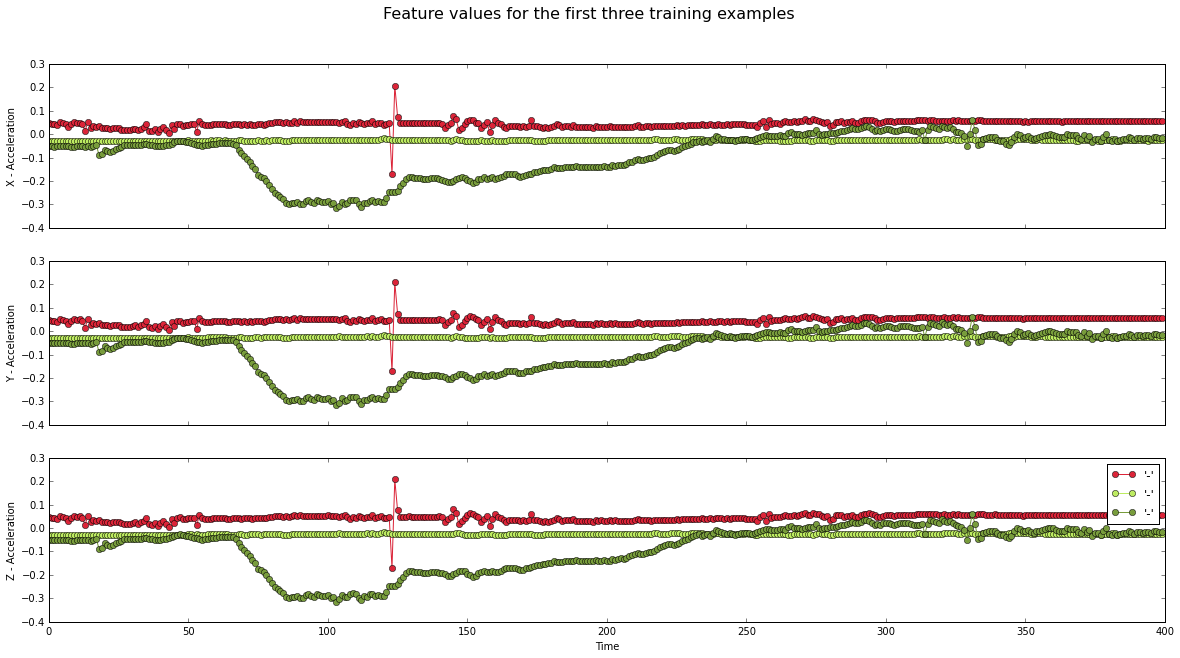

In [21]:
from muvr.visualization.example import plot_examples

# Choose some random examples to plot from the training data
number_of_examples_to_plot = 3
plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, number_of_examples_to_plot)

print "Ids of plotted examples:",plot_ids

figure = plot_examples(dataset, plot_ids)

Now we are going to create a neon model. We will start with a realy simple one layer preceptron having 500 hidden units.

In [24]:
from muvr.training.trainer import MLPMeasurementModelTrainer
from muvr.training.default_models import generate_default_activity_model

mlpmodel = MLPMeasurementModelTrainer(
    working_directory, 
    lrate=0.001,
    max_epochs=10, 
    batch_size=64)

model = mlpmodel.train(dataset, generate_default_activity_model(dataset.num_labels))

Epochs: 10 Batch-Size: 64
Starting training...
[1200, 'id', 250, 'relu', 50, 'relu', 2, 'logistic']
Epoch 0   [Train |████████████████████| 2590/2590 batches, 0.42 cost, 30.59s] [CrossEntropyMulti Loss 0.37, 1.27s]
Epoch 1   [Train |███████████████████ | 2583/2590 batches, 0.23 cost, 28.91s] [CrossEntropyMulti Loss 0.25, 1.55s]
Epoch 2   [Train |███████████████████ | 2582/2590 batches, 0.24 cost, 35.82s] [CrossEntropyMulti Loss 0.15, 1.69s]
Epoch 3   [Train |███████████████████ | 2585/2590 batches, 0.15 cost, 34.43s] [CrossEntropyMulti Loss 0.11, 1.45s]
Epoch 4   [Train |███████████████████ | 2587/2590 batches, 0.06 cost, 32.14s] [CrossEntropyMulti Loss 0.08, 1.30s]
Epoch 5   [Train |████████████████████| 2590/2590 batches, 0.06 cost, 33.35s] [CrossEntropyMulti Loss 0.07, 1.36s]
Epoch 6   [Train |███████████████████ | 2586/2590 batches, 0.06 cost, 30.51s] [CrossEntropyMulti Loss 0.05, 1.34s]
Epoch 7   [Train |███████████████████ | 2583/2590 batches, 0.05 cost, 31.47s] [CrossEntropyMult

To check weather the network is learning something we will plot the weight matrices of the different training epochs.

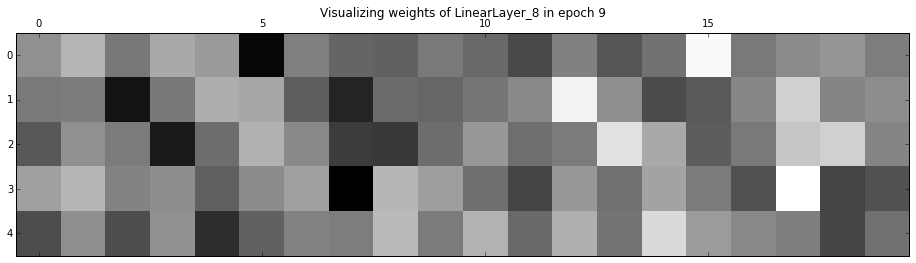

In [25]:
import numpy as np
import math
from matplotlib import pyplot, cm
from pylab import *
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import IntSlider
from muvr.util.utils import closestSqrt

layer_names = map(lambda l: l[1].name+"_"+str(l[0]), filter(lambda l: l[1].has_params, enumerate(model.layers.layers)))

def plot_filters(**kwargs):
    n = kwargs['n']
    layer_name = kwargs['layer']
    dest_path = os.path.join(working_directory, 'workout-mlp-ep_' + str(n))
    params = pkl.load(open(dest_path, 'r'))
    
    wts = params['layer_params_states'][layer_names.index(layer_name)]['params']['W']

    nrows, ncols = closestSqrt(wts.shape[0])
    fr, fc = closestSqrt(wts.shape[1])
    
    fi = 0

    W = np.zeros((fr*nrows, fc*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fc*col:fc*(col+1)] = wts[fi].reshape(fr,fc)
        fi = fi + 1

    matshow(W, cmap=cm.gray)
    title('Visualizing weights of '+layer_name+' in epoch ' + str(n) )
    show()

_i = interact(plot_filters,
              layer=widgets.widget_selection.ToggleButtons(options = layer_names),
              n=IntSlider(description='epochs',
                                        min=0, max=mlpmodel.max_epochs-1, value=0, step=1))

Let's visualize the error to see if the network has trained properly or if we are overfitting.

Test error = 0.9%
Train error = 0.9%
Minibatches per epoch: 2589.20


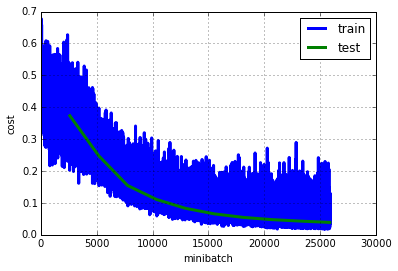

In [26]:
import h5py
from neon.transforms import Misclassification

logged = h5py.File(os.path.join(working_directory, 'workout-mlp.h5'), "r")
epochs = logged['config'].attrs['total_epochs']
minibatches = logged['config'].attrs['total_minibatches']

print('Test error = %.1f%%'
      % (model.eval(dataset.test(), metric=Misclassification())*100))

print('Train error = %.1f%%'
      % (model.eval(dataset.train(), metric=Misclassification())*100))

print "Minibatches per epoch: %0.2f" % (minibatches * 1.0/epochs)

pyplot.plot(range(0, minibatches), logged['cost/train'], linewidth=3, label='train')
pyplot.plot(range(minibatches / epochs, minibatches, minibatches / epochs -1), logged['cost/loss'], linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("minibatch")
pyplot.ylabel("cost")
pyplot.show()

Let's also have a look at the confusion matrix for the test dataset.

In [27]:
from sklearn.metrics import confusion_matrix
from ipy_table import *

def predict(model, dataset):
    running_error = 0.0
    nprocessed = 0
    dataset.reset()
    predictions = np.empty((2, 0), dtype="float32")
    nprocessed = 0
    for x, t in dataset:
        pred = model.fprop(x, inference=True).asnumpyarray()
        bsz = min(dataset.ndata - nprocessed, model.be.bsz)
        nprocessed += bsz
        predictions = np.hstack((predictions, pred[:,:bsz]))
    return predictions

# confusion_matrix(y_true, y_pred)
predicted = predict(model, dataset.test())

y_true = dataset.y_test
y_pred = np.argmax(predicted, axis = 0) 

confusion_mat = confusion_matrix(y_true, y_pred, range(0,dataset.num_labels))

# Fiddle around with cm to get it into table shape
confusion_mat = vstack((np.zeros((1,dataset.num_labels), dtype=int), confusion_mat))
confusion_mat = hstack((np.zeros((dataset.num_labels + 1, 1), dtype=int), confusion_mat))

table = confusion_mat.tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[0][i+1] = s
    table[i+1][0] = s

table[0][0] = "actual \ predicted"

mt = make_table(table)
set_row_style(0, color='lightGray', rotate = "315deg")
set_column_style(0, color='lightGray')
set_global_style(align='center')

for i in range(1, dataset.num_labels + 1):
    for j in range(1, dataset.num_labels + 1):
        if i == j:
            set_cell_style(i,j, color='lightGreen', width = 80)
        elif table[i][j] > 20:
            set_cell_style(i,j, color='Pink')
        elif table[i][j] > 0:
            set_cell_style(i,j, color='lightYellow')
mt

actual \ predicted,-,E
-,30279,280
E,106,10749


In [ ]:
from converters import neon2iosmlp

# Save the model and the information about the model to disc

dataset.save_labels(os.path.join(working_directory, model_name + '_model.labels.txt'))
neon2iosmlp.convert(mlpmodel.model_path, os.path.join(working_directory, model_name + '_model.weights.raw'))

layers = mlpmodel.layers(dataset, model)
neon2iosmlp.write_layers_to_file(layers, os.path.join(working_directory, model_name + '_model.layers.txt'))

(59616, 2)


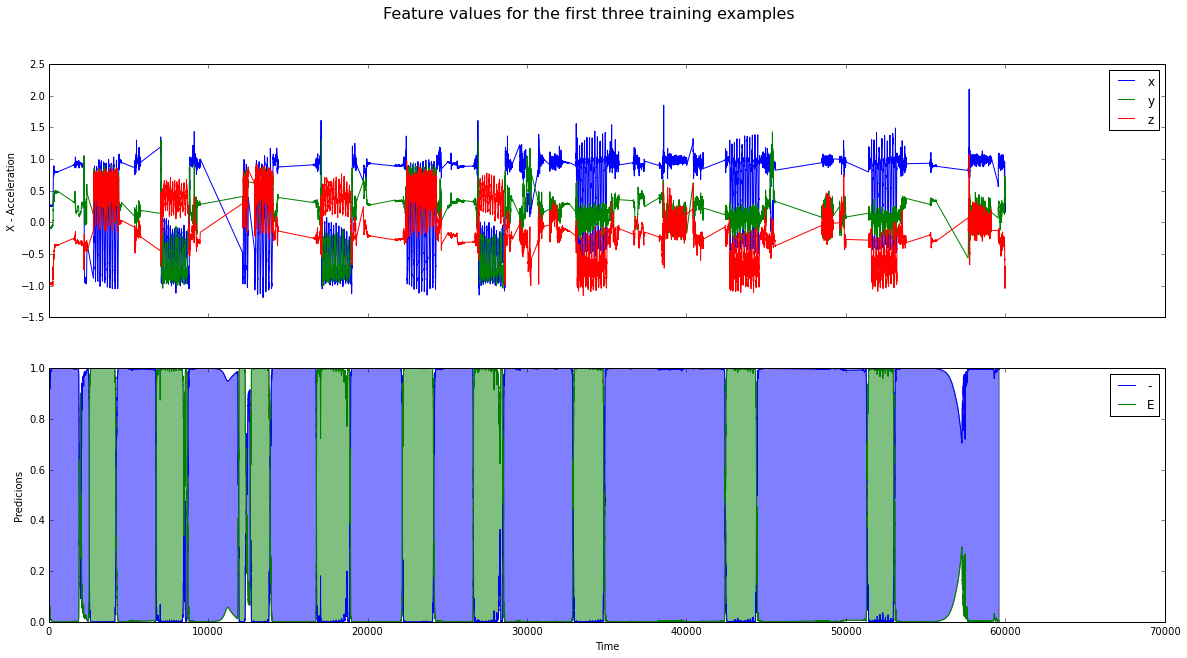

In [29]:
from neon.data import DataIterator
import csv
from matplotlib import pyplot, cm
from pylab import *

test_file = "/Users/tombocklisch/Google Drive/arms_F61331A9-DE21-4DBF-9F84-76030F5EC273.csv"

csvfile = open(test_file, 'rb')

dialect = csv.Sniffer().sniff(csvfile.read(1024))
csvfile.seek(0)
csv_data = csv.reader(csvfile, dialect)

x_buffer = []
for row in csv_data:
    if len(row) == 7:
        # New format (len = 7)
        #   X | Y | Z | '' | '' | '' | ''(without label)
        #   X | Y | Z | biceps-curl | intensity | weight | repetition
        new_data = row[0:3]
        x_buffer.append(new_data)
    else:
        raise Exception("Bad format")

x = np.transpose(np.reshape(np.asarray(x_buffer, dtype=float), (len(x_buffer), len(x_buffer[0]))))

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)    

w = rolling_window(x, 400)

features = w.transpose([1,2,0]).reshape((w.shape[1], -1))

ds = DataIterator(
        X=features,
        nclass=dataset.num_labels,
        make_onehot=True,
        lshape=(dataset.num_features, 1, 1))

predictions = model.get_outputs(ds)


### PLOT THE RESULTS

figure(figsize=(20,10))
p1 = subplot(211)
setp(p1.get_xticklabels(), visible=False)
p1.set_ylabel('X - Acceleration')

p2 = subplot(212, sharex=p1)
p2.set_ylabel('Predicions')

print predictions.shape

p1.plot(range(0,x.shape[1]), x.transpose([1,0]))
p1.legend(["x", "y", "z"])

prange = range(0,len(predictions))
p2.plot(prange, predictions)  
p2.fill_between(prange, predictions[:,0], predictions[:,1], where=predictions[:,0] >= predictions[:,1], facecolor='blue', alpha=0.5)
p2.fill_between(prange, predictions[:,0], predictions[:,1], where=predictions[:,1] >= predictions[:,0], facecolor='green', alpha=0.5)
p2.legend(dataset.ordered_labels())

suptitle('Feature values for the first three training examples', fontsize=16)
xlabel('Time')
show()
